# Problem 6
A flea starts at $(0,0)$ on the infinite two-dimensional integer lattice and executes a biased random walk: At each step, it hops north or south with probability 1/4, east with probability 1/4 + $\epsilon$, and west with probability $ 1/4 - \epsilon$. The probability that the flea returns to $(0,0)$ sometime during its wanderings is 1/2. What is $\epsilon$?

### Attempt 1: Linear System
(Following notation and exposition in Section 6.2 of Bornemann's book)

Let $p_N, p_S, p_E, p_W$ be the probabilities that the flea goes north, south, east, and west respectively, and define $q(x,y)$ to be the probability that the flea returns to the origin from this point. We therefore have that $q(0,0) = 1$ and that the probability that the flea ever returns to the origin is $$ p = p_E q(1,0) + p_W q(-1,0) + p_N q(0,1) + p_S q(0,-1) $$

Note as well that q satisfies the following linear equation:

$$q(x,y) = p_E q(x+1, y) + p_W q(x-1,y) + p_N q(x,y+1)+ p_S q(x,y-1) $$

So, if we restrict $ (x,y) $ such that $ |x|,|y| < N $ and have that $g(x,y) = 0$ otherwise, we get a system of $(2n+1)^2 $ linear equations. 

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
from scipy.optimize import bisect
import time
def solve(N, eps):
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps
    pts = [(x,y) for x in range(-N,N+1) for y in range(-N,N+1)]
    # we form a linear equation A x = 0, where x = [q(x_i, y_i)]

    matrix = [] # entries are tuples (i,j,A_ij)
    for i, pt in enumerate(pts):
        if pt == (0,0):
            matrix.append((i,i,1))
        else:
            x,y = pt
            entries = []
            entries.append((i,i,1))
            if (x+1,y) in pts: entries.append((i,pts.index((x+1,y)),-pE))
            if (x-1,y) in pts: entries.append((i,pts.index((x-1,y)),-pW))
            if (x,y+1) in pts: entries.append((i,pts.index((x,y+1)),-pN))
            if (x,y-1) in pts: entries.append((i,pts.index((x,y-1)),-pS))
            matrix.extend(entries)
    row = np.array([i[0] for i in matrix])
    col = np.array([i[1] for i in matrix])
    data = np.array([i[2] for i in matrix])
    A = coo_matrix((data, (row,col))).tocsc()
#    A = coo_matrix((data, (row,col))).todense()
    b = np.array([0]*A.shape[0])
    b[pts.index((0,0))] = 1
#    q = np.linalg.solve(A,b)
    q = spsolve(A,b)
    p = pE*q[pts.index((1,0))] + pW*q[pts.index((-1,0))] + pN*q[pts.index((0,1))] + pS*q[pts.index((0,-1))]
    return p
"""
solutions = []
interval = (0, 0.25)
for n in [5,10,20,40,80]:
    start = time.time()
    solution = bisect(lambda eps: solve(n, eps) - 0.5, interval[0], interval[1])
    solutions.append(solution)
    interval = (solutions[-1]-0.1, solutions[-1]+0.1)
    end = time.time()
    print("Estimating with n = {}: ε = {}, time elapsed: {} seconds".format(n, solution, end-start))
"""
solve(10,0)

0.6159165778253386

### Attempt 2: Combinatorics
We define $ E $ to be the flea's expected number of visits to the origin. Note that 
$$ E = \sum_{k>0} k P(\text{flea returns to origin in k steps}) = \sum_{k=1}^\infty k p^{k-1} (1-p) = \frac{1}{1-p}$$


Next, note that any walk of the flea that returns to the origin has to take an even number of steps. Note also that any such walk of $2k$ steps must have an equal number of steps going north and south as well as an equal number of steps going east and west. Therefore, defining $p_{2k}$ to be the probability that the flea returns to the origin after $2k$ steps, we get

$$p_{2k} = \sum_{j=0}^{k}\binom{2k}{j,j,k-j,k-j} p_{N}^j p_{S}^j p_{E}^{k-j} p_{W}^{k-j} = \sum_{j=0}^k \binom{2k}{k} \binom{k}{j}^2 (p_{E} p_{W})^{k-j} (p_{N} p_{S} )^{j} $$

Finally, note that we can write $E = \sum_{k>0} E(\text{flea returns to origin after 2k steps}) = \sum_{k=1}^\infty p_k $. 


In [ ]:
# from math import factorial
from fractions import Fraction
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
import time
from mpmath import *
from functools import lru_cache
factorial = fac
mp.dps = 50
@lru_cache(maxsize=None)
def C(n,k):
    return factorial(n)/factorial(k)/factorial(n-k)
def solve2(N, eps):
    print(N, eps)
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps 
    return sum([
        sum([C(2*n, n) * C(n,k)**2 * (pN*pS)**k * (pE*pW)**(n-k) for k in arange(n+1)
        ]) for n in arange(N)
    ])

solutions = []
interval = (0, 0.25)
for n in map(mpf,[100,200,400,800]):
    start = time.time()
    solution = bisect(lambda eps: solve2(n, eps) - 2, interval[0], interval[1])
    solutions.append(solution)
    interval = (solutions[-1]-0.1, solutions[-1]+0.1)
    end = time.time()
    print("Estimating with n = {}: ε = {}, time elapsed: {} seconds".format(n, solution, end-start))

100.0 0.0
100.0 0.25
100.0 0.125
100.0 0.0625
100.0 0.03125
100.0 0.046875
100.0 0.0546875
100.0 0.05859375
100.0 0.060546875
100.0 0.0615234375
100.0 0.06201171875
100.0 0.061767578125
100.0 0.0616455078125
100.0 0.06158447265625
100.0 0.061553955078125
100.0 0.0615386962890625
100.0 0.06154632568359375
100.0 0.061550140380859375
100.0 0.06154823303222656
100.0 0.061547279357910156
100.0 0.06154680252075195
100.0 0.06154656410217285
100.0 0.0615466833114624
100.0 0.06154662370681763
100.0 0.061546653509140015
100.0 0.06154663860797882
100.0 0.06154664605855942
100.0 0.061546649783849716
100.0 0.06154664792120457
100.0 0.06154664698988199
100.0 0.061546646524220705
100.0 0.06154664629139006
100.0 0.06154664617497474
100.0 0.06154664611676708
100.0 0.06154664614587091
100.0 0.061546646160422824
100.0 0.06154664615314687
100.0 0.061546646156784846
100.0 0.061546646154965856
Estimating with n = 100.0: ε = 0.061546646154965856, time elapsed: 10.222291231155396 seconds
200.0 -0.038453353845

### Attempt 3: Symbolic manipulation

Let's try to evaluate this sum symbolically - hopefully, we'll get quicker computation times by using special functions...

(Note, below we let $x = p_E p_W, y = p_N p_S$)

In [57]:
from sympy import *
init_printing()
x,y = symbols("x y")
n,k = symbols("n k", integer=True, positive=True)
Sum(binomial(n,k)**2 * x**(n-k) * y**k, (k,0,n)).doit()

   ⎛⎧ ┌─  ⎛-n, -n │ y⎞      │y│    ⎞
   ⎜⎪ ├─  ⎜       │ ─⎟  for │─│ ≤ 1⎟
   ⎜⎪2╵ 1 ⎝  1    │ x⎠      │x│    ⎟
   ⎜⎪                              ⎟
   ⎜⎪  n                           ⎟
   ⎜⎪ ____                         ⎟
 n ⎜⎪ ╲                            ⎟
x ⋅⎜⎨  ╲             2             ⎟
   ⎜⎪   ╲   -k  k ⎛n⎞              ⎟
   ⎜⎪   ╱  x  ⋅y ⋅⎜ ⎟    otherwise ⎟
   ⎜⎪  ╱          ⎝k⎠              ⎟
   ⎜⎪ ╱                            ⎟
   ⎜⎪ ‾‾‾‾                         ⎟
   ⎜⎪False                         ⎟
   ⎝⎩                              ⎠

Therefore, we have that 
$$\sum_{n=0}^{\infty}\sum_{k=0}^n \binom{2n}{n} \binom{n}{k}^2 x^{n-k} y^{k} = \sum_{n=0}^{\infty} \binom{2n}{n} x^n {{}_{2}F_{1}\left(\begin{matrix} - n, - n \\ 1 \end{matrix}\middle| {\frac{y}{x}} \right)} $$

In [58]:
from scipy.special import hyp2f1, comb as C
import numpy as np
import matplotlib.pyplot as plt

def solve4(N, eps):
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps 
    x,y = pE*pW, pN*pS
    return sum([C(2*n,n)*y**n*hyp2f1(-n,-n,1,x/y) for n in range(N+1)])

for n in [2**i for i in range(5,12)]:
    start = time.time()
    solution = bisect(lambda eps: solve4(n, eps) - 2, 0, 0.25)
    end = time.time()
    print("Estimating with n = {}: ε = {}, time elapsed: {} seconds".format(n, solution, end-start))

NameError: ignored

We again get overflow: define $a_n = \binom{2n}{n} y^n $ recursively as follows:

$$\cases{
    1 \; \text{if n=0} \\
    \frac{2y(1+2n)}{1+n} \cdot a_{n-1} \\
}$$

We also use the mpmath Python library for arbitrary precision.

In [ ]:
from functools import lru_cache
from mpmath import *

mp.dps = 50

def solve5(N,eps):
    print(eps)
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps 
    x,y = pE*pW, pN*pS
    @lru_cache(maxsize=None)
    def a(n):
        if n==0: return 1
        return 2*y*(2*n-1)/n*a(n-1)
    return sum([a(n)*hyp2f1(-n,-n,1,x/y) for n in range(N)])

f = lambda N: findroot(lambda eps: solve5(N,eps)-2, 0.06)
f(5000)

We're pulling out all the stops for this one - let's find an analytic expression for $E$. First, rewrite the hypergeometric function as follows (below, we let $z = y/x$):

$ {_{2}F_{1}\left(\begin{matrix} - n, - n \\ 1 \end{matrix}\middle| {z} \right)} $

$ = {_{2}F_{1}\left(\begin{matrix} - n, n+1 \\ 1 \end{matrix}\middle| {\frac{z}{z-1}} \right)}  (1-z)^n $ (see [15.8.1](https://dlmf.nist.gov/15.8)

Next, note that we have that the *Jacobi polynomials* are defined by the following:

$$ P_{n}^{(\alpha ,\beta )}(z)={\frac {(\alpha +1)_{n}}{n!}}\,{}_{2}F_{1}\left(-n,1+\alpha +\beta +n;\alpha +1;{\tfrac {1}{2}}(1-z)\right) $$

Letting $\alpha=\beta=0, z' = \frac{1+z}{1-z}$, we get 

$$ P_{n}^{(0 ,0 )}(z')={\frac {(1)_{n}}{n!}}\,{}_{2}F_{1}\left(-n,n+1; 1; \frac{z}{z-1} \right) $$

Therefore, we get
$$ {_{2}F_{1}\left(\begin{matrix} - n, - n \\ 1 \end{matrix}\middle| {z} \right)} = (1-z)^n \frac{n!}{(1)_n} P_n^{(0,0)}(z') = (1-z)^n P_n^{(0,0)}\left(\frac{1+z}{1-z}\right)$$

So, we have that $E= \sum_{n=0}^{\infty}\sum_{k=0}^n \binom{2n}{n} \binom{n}{k}^2 x^{n-k} y^{k} = \sum_{n=0}^{\infty} \binom{2n}{n} x^n {{}_{2}F_{1}\left(\begin{matrix} - n, - n \\ 1 \end{matrix}\middle| {\frac{y}{x}} \right)} = \sum_{n=0}^\infty \binom{2n}{n} (x-y)^n P^{\ell}_n (\frac{x+y}{x-y})$ 

where $P^{\ell}$ are the Legendre polynomials.

Note that since $P^\ell_k(x) = \frac{1}{\pi} \int_0^\pi (x+\sqrt{x^2-1} \cos{\theta})^k d\theta$, we have that 

$$\sum_{n=0}^\infty a_n P^\ell_n(x) z^n = \frac{1}{\pi} \int_0^\pi \sum_{n=0}^\infty a_n (x+\sqrt{x^2-1}\cos{\theta})^n z^n = \frac{1}{\pi} \int_0^\pi f \left((x+\sqrt{x^2-1} \cos{\theta}) z \right) d\theta$$

where $f(z) = \sum_{k=0}^\infty a_k z^k $



In [ ]:
from sympy import *
init_printing()
x,y,z,t = symbols("x y z t")
n,k = symbols("n k",integer=True)
a,b = symbols("a b")
f = lambda a,z: Sum(a(k) * z**k, (k,0,oo)).doit()

"""
a = (x+y)/(x-y)
b = x-y
"""
temp = f(lambda k: binomial(2*k,k), (a+sqrt(a*a-1)*cos(t))*b)
integrand = temp.args[0][0]
factor(integrand)

Using the identity $\int_0^\pi \frac{dt}{\sqrt{A+B\cos{t}}} = \frac{2K(-\frac{2B}{A-B})}{\sqrt{A-B}}$ (where K is the [complete elliptic integral of the first kind](https://en.wikipedia.org/wiki/Elliptic_integral#Complete_elliptic_integral_of_the_first_kind), we get that, after letting $ A = 1-4ab, B = -4b \sqrt{a^2-1} $ that 

In [ ]:
from sympy import *
x,y,z,t = symbols("x y z t")
n,k = symbols("n k",integer=True)
a,b = symbols("a b")
integrand_eval = lambda A,B: 2*elliptic_k(-2*B/(A-B))/sqrt(A-B)


a = (x+y)/(x-y)
b = x-y

A = 1-4*a*b
B = -4*b*sqrt(a*a-1)
collect(integrand_eval(A,B),y)

We get something involving an elliptic integral - I may have made some algebra mistake along the way so instead, we'll use a result cited in the paper "Some explicit results for an asymmetric two-dimensional random walk".

We get that (switching notation to what's used in the paper with $ p = p_E, q = p_W, r = p_N, s = p_S ) $ that the return probability is $ p = 1 - \frac{\pi\sqrt{d}}{2K(4\sqrt{pqrs}/d)} $  with $ d= \frac{1}{2} \left( (1-4pq-4rs) + \sqrt{(1-4pq-4rs)^2 - 64pqrs} \right)$

Plugging in $ p = 1/4+\epsilon, q = 1/4-\epsilon, r=s=1/4 $, we get that

In [ ]:
from sympy import *
init_printing()
p,q,r,s= symbols("p q r s")
"""
eps = symbols("epsilon")
p = Rational(1,4) + eps
q = Rational(1,4) - eps
r = s = Rational(1,4)
"""
d = (1-4*p*q-4*r*s+sqrt((1-4*p*q-4*r*s)**2 - 64*p*q*r*s))/2
E_ = 2 / (pi*sqrt(d)) * elliptic_k((4*sqrt(p*q*r*s)/d)**2) # Note here that we square the argument due to different conventions around the elliptic integral 
E = lambdify((p,q,r,s),E_, modules="mpmath")

In [ ]:
temp = lambda eps: E(0.25+eps, 0.25-eps, 0.25, 0.25)
import numpy as np
from mpmath import *
mp.dps = 1000
findroot(lambda x: temp(x)-2,0.06)

### Ignore

We are dealing with some overflow errors as the binomial coefficients grow very large - therefore, we calcuate each term recursively as mentioned in Bornemann p 133:

$$ p_k = a_k \sum_{j=0}^k b_j $$ where $a_k = \cases{
    1 \; \text{if k=0}\\ 
    \frac{2k(2k-1)}{k^2}(p_N p_S)^2 \cdot a_{k-1} \; \text{otherwise} \\
}, b_j = \cases{
    1 \; \text{if j=0} \\
    (\frac{k-j+1}{j} \cdot \frac{p_E p_W}{p_N p_S})^2 \cdot b_{j-1} \; \text{otherwise} \\
    }$

In [ ]:
from functools import lru_cache
from math import isnan, factorial
from scipy.optimize import bisect
import numpy as np
import matplotlib.pyplot as plt
C = lambda n,k: factorial(n)//factorial(k)//factorial(n-k)
def solve3(N, eps):
    pN, pS, pE, pW = 0.25, 0.25, 0.25+eps, 0.25-eps
    pEW = pE*pW; pNS = pN * pS
    def a(k):
        if k==0: return 1
        return a(k-1) * (2*k*(2*k-1))/(k*k) * (pNS)**2
    def b(j,k):
        if j==0: return 1
        return b(j-1,k) * ((k-j+1)/j)**2 * (pEW / pNS)
    def p(k):
        return a(k)*sum([b(j,k) for j in range(0,k+1)])
    #print( [a(k) for k in range(10)], "\n", [C(2*k,k)*pNS**(2*k) for k in range(10)])
    print([b(j,10) for j in range(1,10)], "\n", [C(10,j)**2 * (pEW/pNS)**(2*j) for j in range(1,10)])
    return [p(k) for k in range(N)]
solve3(10,0.2) 
# bisect(lambda eps: solve3(1000, eps) - 2, 0, 0.25)

[35.99999999999999, 262.4399999999999, 671.8463999999996, 740.7106559999993, 383.9844040703996, 95.9961010175999, 11.284439629823986, 0.5712747562598393, 0.010155995666841585] 
 [12.959999999999994, 34.012223999999975, 31.34566563839996, 12.441094691880942, 2.321806855777588, 0.2089626170199828, 0.008842956788829312, 0.00016116288747641415, 1.03144247984905e-06]


⎧ n  ┌─  ⎛-n, -n │ x⎞      │x│    
⎪y ⋅ ├─  ⎜       │ ─⎟  for │─│ ≤ 1
⎪   2╵ 1 ⎝  1    │ y⎠      │y│    
⎪                                 
⎪  n                              
⎪ ____                            
⎪ ╲                               
⎨  ╲                2             
⎪   ╲   k  -k  n ⎛n⎞              
⎪   ╱  x ⋅y  ⋅y ⋅⎜ ⎟    otherwise 
⎪  ╱             ⎝k⎠              
⎪ ╱                               
⎪ ‾‾‾‾                            
⎪False                            
⎩                                 

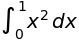

In [ ]:
Integral(x**2,(x,0,1))